# Bayesian - Gaussian random walk
### Attitudinal aggregation - 2028 Election

## Python set-up

In [1]:
"""Setup and imports."""

import sys
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import mgplot as mg
import numpy as np
import pandas as pd

# Add pymc tools to path
sys.path.insert(0, "pymc")

from bayes_tools import check_residuals, draw_samples, grw_model, prepare_data_for_analysis
from common import MIDDLE_DATE
from extraction import get_vector_var
from plot_house_effects import plot_house_effects_bar
from plot_posterior_timeseries import plot_posterior_timeseries
from plot_posteriors_bar import plot_posteriors_bar
from polling_data_etl import load_polling_data

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

SHOW = True
RFOOTER = "marktheballot.blogspot.com"
LFOOTER = "Australia. Polling data sourced from Wikipedia. "

In [2]:
# Set up plotting directory
mg.set_chart_dir("../charts/bayesian-attitudinal/")
mg.clear_chart_dir()

## Load Polling Data

Load the most recent attitudinal polling data using the ETL module.

In [3]:
# Load attitudinal data
df_raw = load_polling_data("preferred_pm")
print(f"\nLoaded {len(df_raw)} polls")
print(f"\nColumns: {list(df_raw.columns)}")

Using today's preferred_pm data file: ../poll-data/preferred_pm_next_2025-12-30.csv

Loaded 31 polls

Columns: ['Date', 'Brand', 'Sample size', 'Preferred prime minister Albanese', 'Preferred prime minister Ley', "Preferred prime minister Don't know", 'Net', 'Albanese Satisfied', 'Albanese Dissatisfied', "Albanese Don't know", 'Albanese Net', 'Ley Satisfied', 'Ley Dissatisfied', "Ley Don't know", 'Ley Net', 'parsed_date']


In [4]:
# Display the raw data
df_raw.head(10)

Date            Brand Sample size  \
parsed_date                                                  
2025-08-12   11 – 14 Aug 2025         Newspoll        1264   
2025-07-15   13 – 18 Jul 2025          Resolve        2311   
2025-07-15   14 – 17 Jul 2025         Newspoll        1264   
2025-10-17   15 – 20 Oct 2025       Freshwater        1530   
2025-12-18   17 – 20 Dec 2025          Resolve        1010   
2025-11-18   17 – 20 Nov 2025         Newspoll        1245   
2025-07-24   18 – 30 Jul 2025     Wolf & Smith        5000   
2025-11-21   19 – 24 Nov 2025        Essential        1020   
2025-12-04     2 – 7 Dec 2025          Resolve        1800   
2025-05-05     2 – 8 May 2025  Morning Consult        3770   

             Preferred prime minister Albanese  Preferred prime minister Ley  \
parsed_date                                                                    
2025-08-12                           51.000000                     31.000000   
2025-07-15                           40.000000                     25.000000   
2025-07-15                           52.000000                     32.000000   
2025-10-17                           47.524752                     30.693069   
2025-12-18                           38.000000                     30.000000   
2025-11-18                           54.000000                     27.000000   
2025-07-24                           45.000000                     35.000000   
2025-11-21                                 NaN                           NaN   
2025-12-04                           41.000000                     26.000000   
2025-05-05                                 NaN                           NaN   

             Preferred prime minister Don't know  Net  Albanese Satisfied  \
parsed_date                                                                 
2025-08-12                             18.000000  20%           49.000000   
2025-07-15                             35.000000  15%           45.000000   
2025-07-15                             16.000000  20%           47.000000   
2025-10-17                             21.782178  17%                 NaN   
2025-12-18                             32.000000   8%           40.000000   
2025-11-18                             19.000000  27%           47.000000   
2025-07-24                             20.000000  10%                 NaN   
2025-11-21                                   NaN  NaN           47.000000   
2025-12-04                             33.000000  15%           48.000000   
2025-05-05                                   NaN  NaN           57.575758   

             Albanese Dissatisfied  Albanese Don't know  Albanese Net  \
parsed_date                                                             
2025-08-12               46.000000             5.000000           3.0   
2025-07-15               42.000000            13.000000           3.0   
2025-07-15               47.000000             6.000000           0.0   
2025-10-17                     NaN                  NaN          -7.0   
2025-12-18               49.000000            11.000000          -9.0   
2025-11-18               47.000000             6.000000           0.0   
2025-07-24                     NaN                  NaN           NaN   
2025-11-21               43.000000            10.000000           4.0   
2025-12-04               43.000000             9.000000           5.0   
2025-05-05               33.333333             9.090909          24.0   

             Ley Satisfied  Ley Dissatisfied  Ley Don't know  Ley Net  \
parsed_date                                                             
2025-08-12            35.0              44.0            21.0     -9.0   
2025-07-15            38.0              29.0            33.0      9.0   
2025-07-15            35.0              42.0            23.0     -7.0   
2025-10-17             NaN               NaN             NaN     -5.0   
2025-12-18            36.0              40.0            24.0     -4.0   
2025-1

## Data Preparation

Prepare the data for Bayesian analysis - ensure correct column names and create derived columns.

In [5]:
# Data preparation
df = df_raw.copy()

# Rename parsed_date to Mean Date for compatibility with bayes_tools
if "parsed_date" in df.columns and MIDDLE_DATE not in df.columns:
    df[MIDDLE_DATE] = pd.to_datetime(df["parsed_date"])

# Identify numeric columns (attitudinal measures)
numeric_cols = [
    "Preferred prime minister Albanese",
    "Preferred prime minister Ley",
    "Preferred prime minister Don't know",
    "Albanese Satisfied",
    "Albanese Dissatisfied",
    "Albanese Don't know",
    "Ley Satisfied",
    "Ley Dissatisfied",
    "Ley Don't know",
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print(f"Prepared {len(df)} polls")
df.head()

Prepared 31 polls


Date       Brand Sample size  \
parsed_date                                             
2025-08-12   11 – 14 Aug 2025    Newspoll        1264   
2025-07-15   13 – 18 Jul 2025     Resolve        2311   
2025-07-15   14 – 17 Jul 2025    Newspoll        1264   
2025-10-17   15 – 20 Oct 2025  Freshwater        1530   
2025-12-18   17 – 20 Dec 2025     Resolve        1010   

             Preferred prime minister Albanese  Preferred prime minister Ley  \
parsed_date                                                                    
2025-08-12                           51.000000                     31.000000   
2025-07-15                           40.000000                     25.000000   
2025-07-15                           52.000000                     32.000000   
2025-10-17                           47.524752                     30.693069   
2025-12-18                           38.000000                     30.000000   

             Preferred prime minister Don't know  Net  Albanese Satisfied  \
parsed_date                                                                 
2025-08-12                             18.000000  20%                49.0   
2025-07-15                             35.000000  15%                45.0   
2025-07-15                             16.000000  20%                47.0   
2025-10-17                             21.782178  17%                 NaN   
2025-12-18                             32.000000   8%                40.0   

             Albanese Dissatisfied  Albanese Don't know  Albanese Net  \
parsed_date                                                             
2025-08-12                    46.0                  5.0           3.0   
2025-07-15                    42.0                 13.0           3.0   
2025-07-15                    47.0                  6.0           0.0   
2025-10-17                     NaN                  NaN          -7.0   
2025-12-18                    49.0                 11.0          -9.0   

             Ley Satisfied  Ley Dissatisfied  Ley Don't know  Ley Net  \
parsed_date                                                             
2025-08-12            35.0              44.0            21.0     -9.0   
2025-07-15            38.0              29.0            33.0      9.0   
2025-07-15            35.0              42.0            23.0     -7.0   
2025-10-17             NaN               NaN             NaN     -5.0   
2025-12-18            36.0              40.0            24.0     -4.0   

            parsed_date  Mean Date  
parsed_date                         
2025-08-12   2025-08-12 2025-08-12  
2025-07-15   2025-07-15 2025-07-15  
2025-07-15   2025-07-15 2025-07-15  
2025-10-17   2025-10-17 2025-10-17  
2025-12-18   2025-12-18 2025-12-18

In [6]:
# Check pollsters (Brand) in the data
print("Pollsters in data:")
print(df["Brand"].value_counts())

Pollsters in data:
Brand
Resolve             7
Newspoll            6
Essential           6
Morning Consult     3
Redbridge           3
YouGov              2
Freshwater          1
Wolf & Smith        1
Spectre Strategy    1
Firm                1
Name: count, dtype: int64


In [7]:
# Date range
print(f"Date range: {df[MIDDLE_DATE].min()} to {df[MIDDLE_DATE].max()}")
print(f"Number of days: {(df[MIDDLE_DATE].max() - df[MIDDLE_DATE].min()).days}")

Date range: 2025-05-05 00:00:00 to 2025-12-18 00:00:00
Number of days: 227


## Data Exploration

In [8]:
# Summary statistics
available_cols = [c for c in numeric_cols if c in df.columns]
df[available_cols].describe()

Preferred prime minister Albanese  Preferred prime minister Ley  \
count                          19.000000                     19.000000   
mean                           45.869724                     27.247004   
std                             5.859477                      4.746224   
min                            38.000000                     12.000000   
25%                            40.500000                     26.000000   
50%                            46.000000                     27.000000   
75%                            51.000000                     30.346535   
max                            54.000000                     35.000000   

       Preferred prime minister Don't know  Albanese Satisfied  \
count                            19.000000           24.000000   
mean                             26.883273           46.295442   
std                               8.919289            4.732991   
min                              16.000000           37.000000   
25%                              19.000000           44.000000   
50%                              23.000000           46.500000   
75%                              34.000000           48.636139   
max                              47.000000           57.575758   

       Albanese Dissatisfied  Albanese Don't know  Ley Satisfied  \
count              24.000000            24.000000      20.000000   
mean               43.371150            10.333408      31.632653   
std                 4.733413             4.887183       7.318834   
min                33.333333             3.000000      13.000000   
25%                40.500000             8.183168      31.000000   
50%                44.000000            10.500000      32.836634   
75%                47.000000            11.250000      35.250000   
max                51.000000            24.000000      41.000000   

       Ley Dissatisfied  Ley Don't know  
count         20.000000       20.000000  
mean          40.744289       27.623057  
std            8.081534        9.763562  
min           29.000000       17.000000  
25%           34.490099       22.500000  
50%           40.500000       25.500000  
75%           44.000000       29.380438  
max           58.000000       53.000000

## Configuration

In [9]:
# Configuration
MIN_POLLS = 3  # Lower threshold for attitudinal (fewer polls available)

# Columns to analyse - attitudinal measures
ATTITUDINAL_COLUMNS = [
    "Preferred prime minister Albanese",
    "Preferred prime minister Ley",
    "Albanese Satisfied",
    "Albanese Dissatisfied", 
    "Ley Satisfied",
    "Ley Dissatisfied",
]

# Palettes for plots
PALETTES = {
    "Albanese": "Reds",
    "Ley": "Blues",
    "Satisfied": "Greens",
    "Dissatisfied": "Oranges",
}


def get_palette(column: str) -> str:
    """Get the palette for a column based on content."""
    # Satisfaction status takes precedence for satisfaction columns
    if "Satisfied" in column and "Dis" not in column:
        return "Greens"
    if "Dissatisfied" in column:
        return "Oranges"
    # Then check for person
    for key, palette in PALETTES.items():
        if key in column:
            return palette
    return "Blues"

## GRW Model Function

In [10]:
def run_grw_for_column(
    df: pd.DataFrame,
    column: str,
    constraint: str = "zero_median",
    min_polls: int = 3,
    draws: int = 5000,
    tune: int = 1000,
    cores: int = 4,
    target_accept: float = 0.80,
    max_tree_depth: int = 12,
    innovation: float = 0.1,
    likelihood: str = "StudentT",
) -> dict:
    """Run GRW model for a single column and return results."""
    
    print(f"\n{'='*60}")
    print(f"Processing: {column}")
    print(f"{'='*60}")
    
    # Filter to rows with valid data for this column
    df_analysis = df[df[column].notna()].copy()
    
    # Get poll counts by pollster
    poll_counts = df_analysis["Brand"].value_counts()
    
    print(f"Polls: {len(df_analysis)}")
    print(f"Pollsters: {list(poll_counts.index)}")
    print(f"Constraint: {constraint}")
    
    # Check minimum data requirements
    if len(df_analysis) < 5:
        print(f"WARNING: Only {len(df_analysis)} polls - skipping (need at least 5)")
        return None
    
    # Prepare data
    if constraint == "zero_sum":
        he_sum_exclusions = poll_counts[poll_counts < min_polls].index.tolist()
        print(f"Excluded from sum-to-zero (n<{min_polls}): {he_sum_exclusions}")
        inputs = prepare_data_for_analysis(
            df_analysis,
            column=column,
            he_sum_exclusions=he_sum_exclusions,
        )
    else:
        inputs = prepare_data_for_analysis(
            df_analysis,
            column=column,
        )
    
    # Build and run model
    model = grw_model(inputs, innovation=innovation, likelihood=likelihood, constraint=constraint)
    idata, glitches = draw_samples(
        model, 
        draws=draws, 
        tune=tune, 
        cores=cores,
        target_accept=target_accept,
        nuts_sampler="numpyro",
        nuts_sampler_kwargs={"nuts_kwargs": {"max_tree_depth": max_tree_depth}},
    )
    
    if glitches:
        print(f"WARNING: {glitches}")
    
    print(f"Completed: {column}")
    
    return {
        "inputs": inputs,
        "model": model,
        "idata": idata,
        "glitches": glitches,
        "constraint": constraint,
        "poll_counts": poll_counts.to_dict(),
    }

## Run GRW Model for All Attitudinal Columns


Processing: Preferred prime minister Albanese
Polls: 19
Pollsters: ['Resolve', 'Newspoll', 'YouGov', 'Freshwater', 'Wolf & Smith', 'Spectre Strategy', 'Redbridge']
Constraint: zero_median
sigma_obs HalfNormal prior: {'sigma': 5}
nu Gamma prior: {'alpha': 2, 'beta': 0.1}


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 1717
Maximum MCSE/sd ratio: 0.024
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (11): 0.05% (comparing to observed max)
Minimum BFMI: 0.93
Completed: Preferred prime minister Albanese


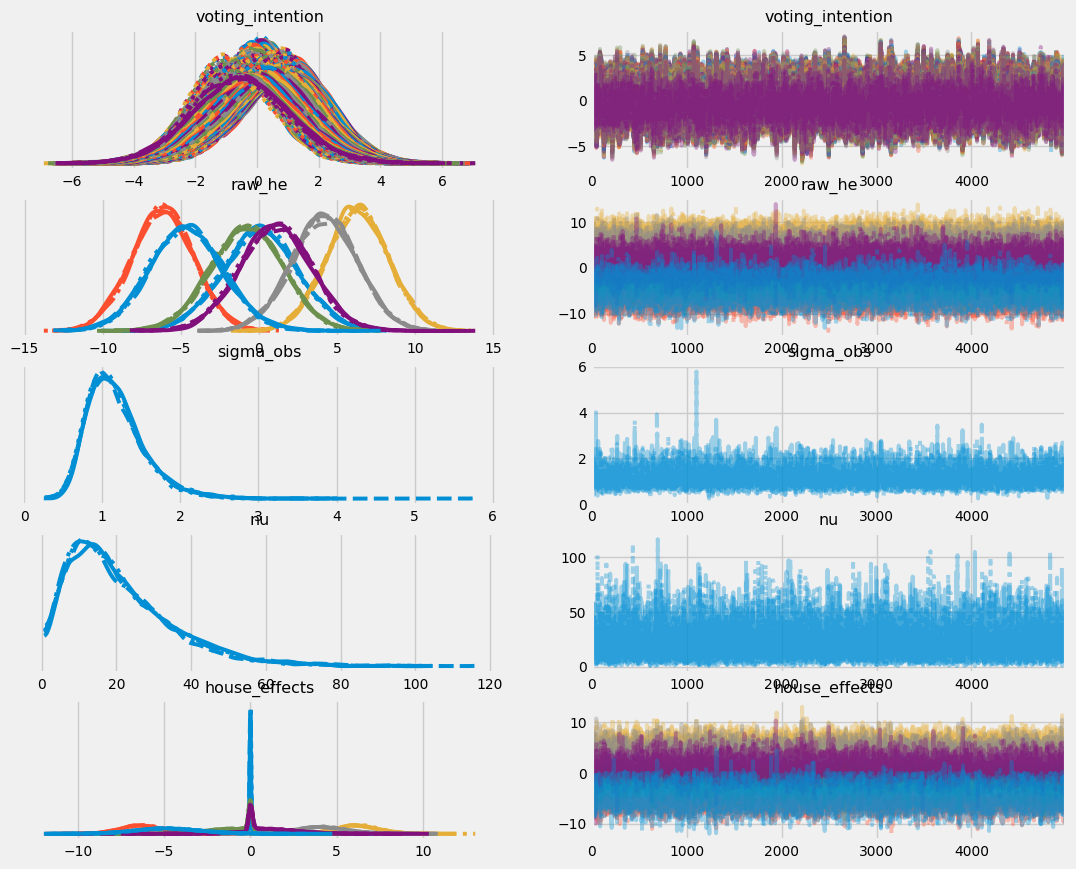

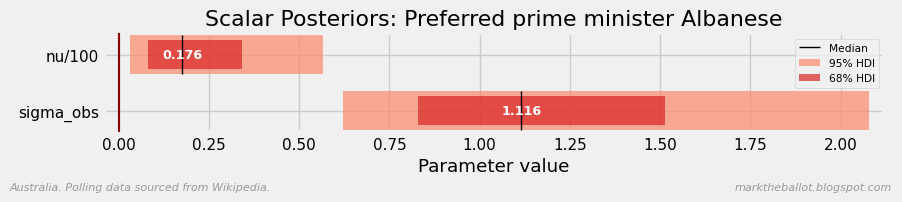

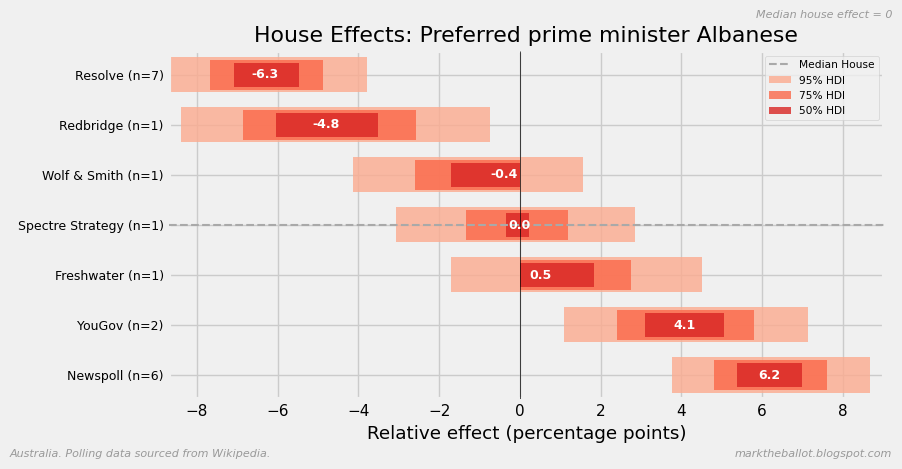

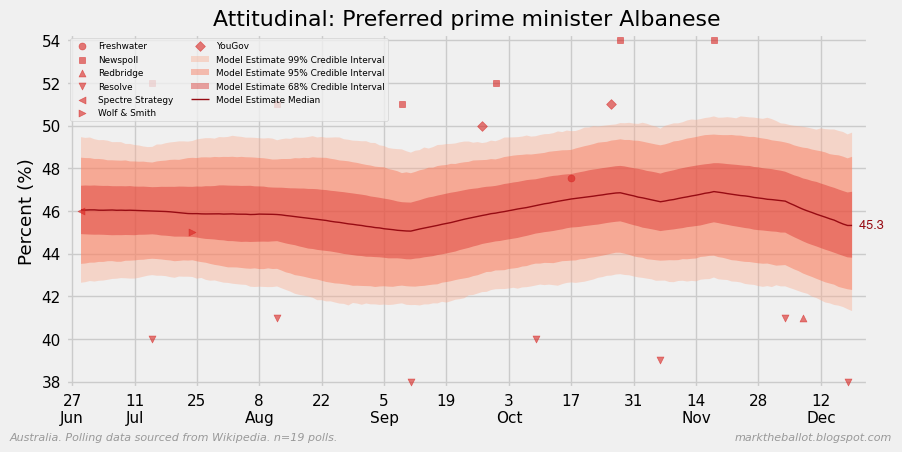


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.17
Minimum polls required: 5

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.799 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.63 (t-test p=0.478)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.412 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.13 (t-test p=0.065)

✓ No pollsters flagged for methodology concerns.

Processing: Preferred prime minister Ley
Polls: 19
Pollsters: ['Resolve', 'Newspoll', 'YouGov', 'Freshwater', 'Wolf & Smith', 'Spectre Strategy', 'Redbridge']
Constraint: zero_median
sigma_obs HalfNormal prior: {'sigma': 5}
nu Gamma prior: {'alpha': 2, 'beta': 0.1}


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 2732
Maximum MCSE/sd ratio: 0.019
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (11): 0.01% (comparing to observed max)
Minimum BFMI: 0.95
Completed: Preferred prime minister Ley


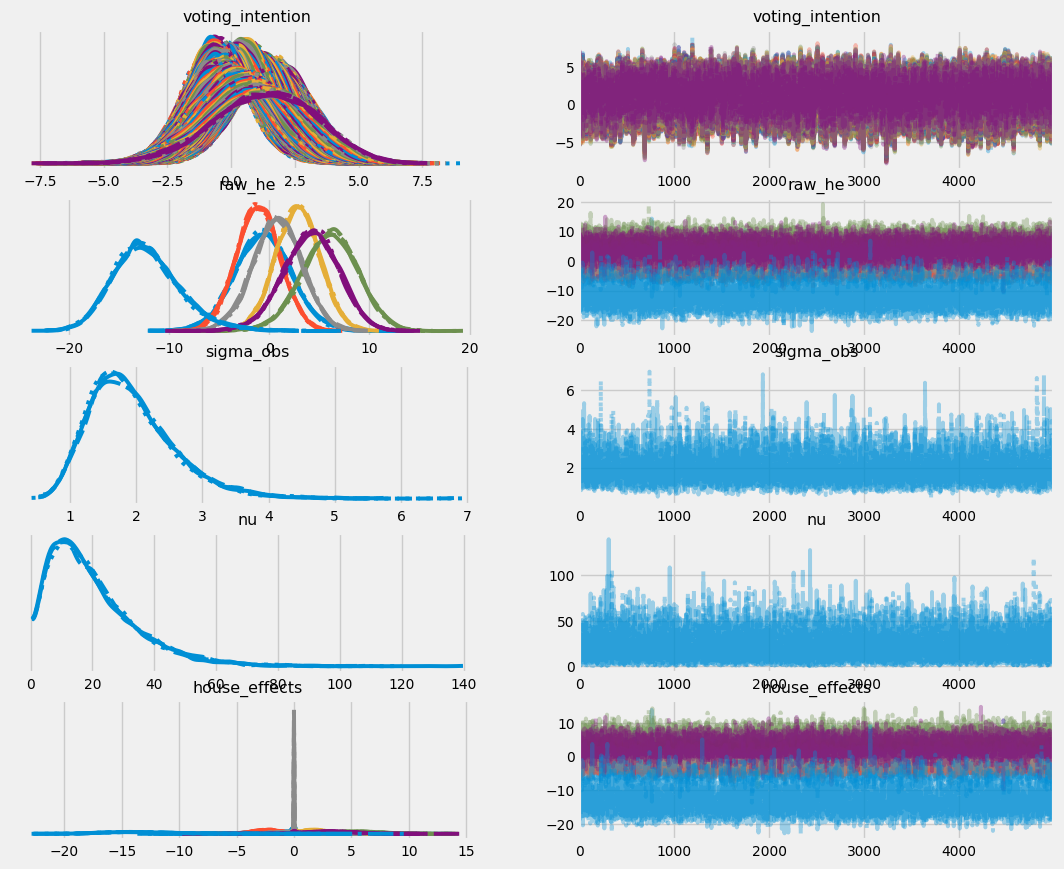

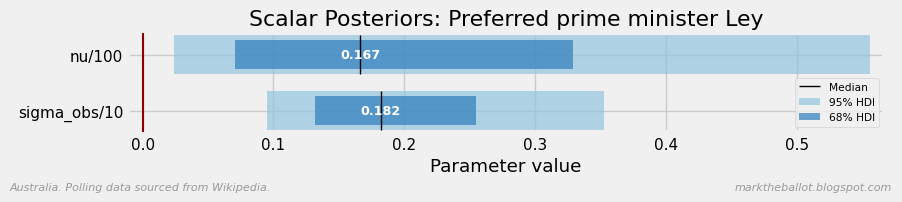

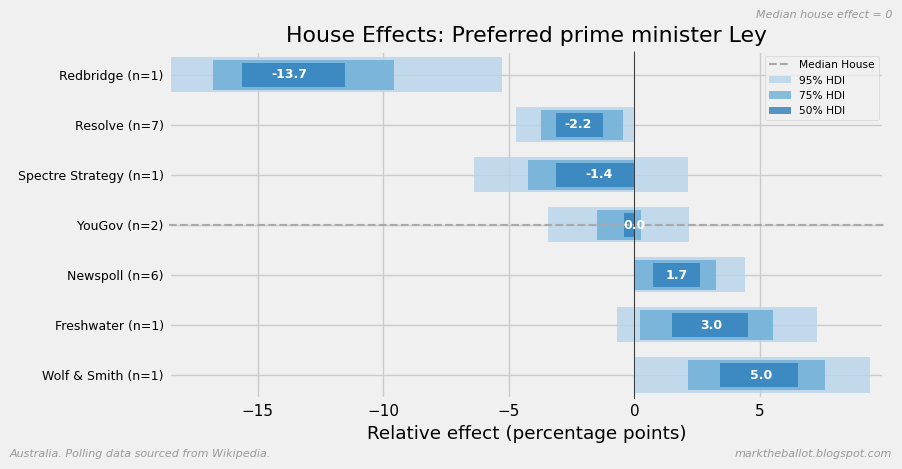

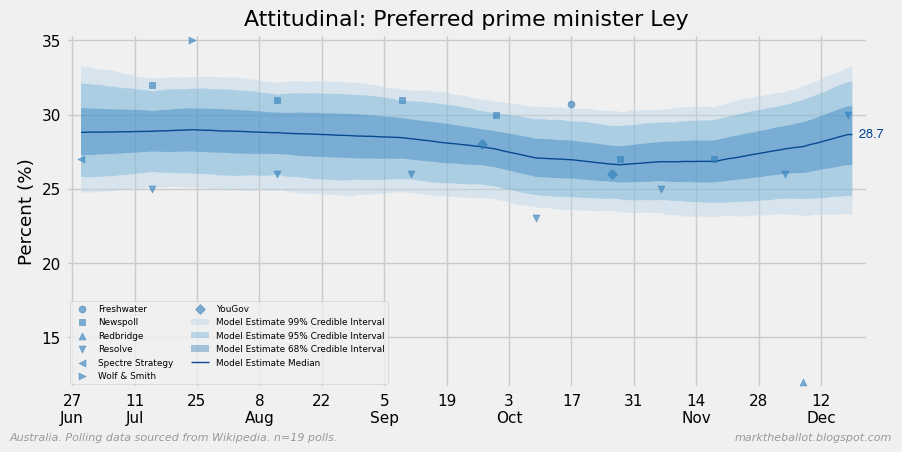


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.93
Minimum polls required: 5

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.315 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.45 (t-test p=0.302)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.445 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -1.71 (t-test p=0.121)

✓ No pollsters flagged for methodology concerns.

Processing: Albanese Satisfied
Polls: 24
Pollsters: ['Resolve', 'Newspoll', 'Essential', 'Morning Consult', 'Redbridge']
Constraint: zero_median
sigma_obs HalfNormal prior: {'sigma': 5}
nu Gamma prior: {'alpha': 2, 'beta': 0.1}


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 4706
Maximum MCSE/sd ratio: 0.015
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (11): 0.01% (comparing to observed max)
Minimum BFMI: 0.97
Completed: Albanese Satisfied


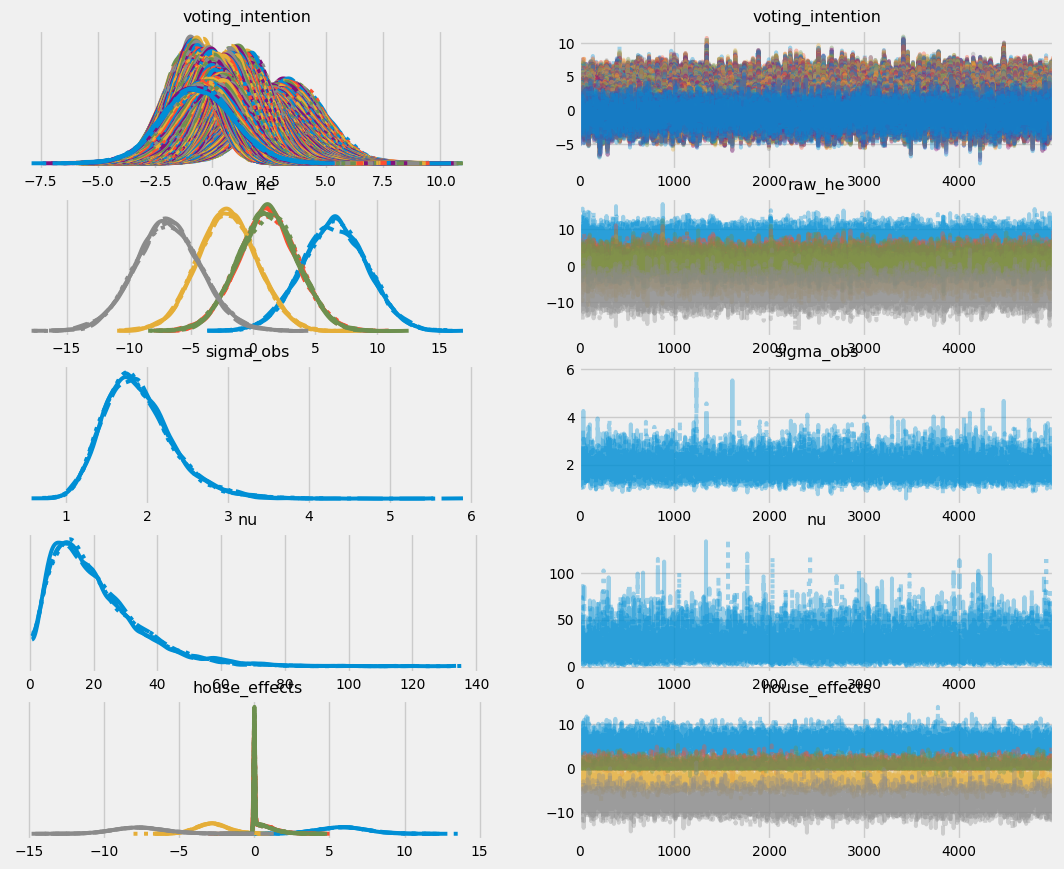

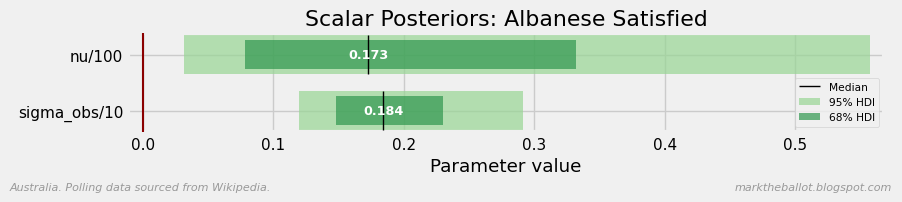

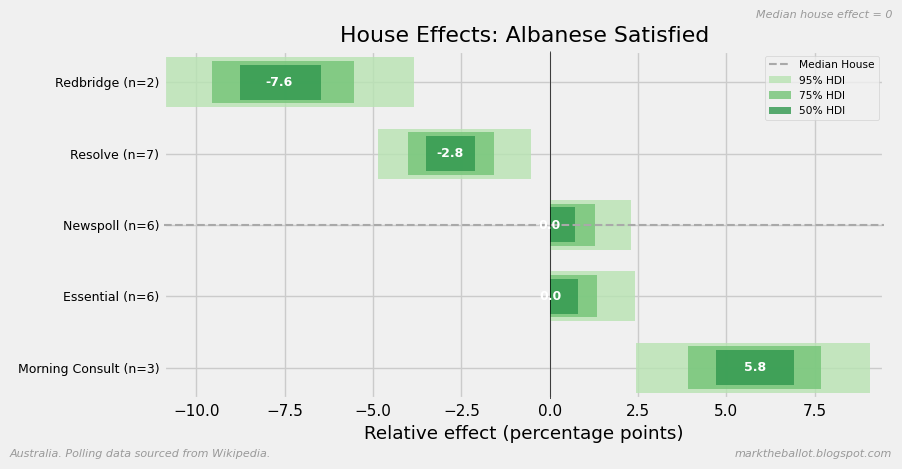

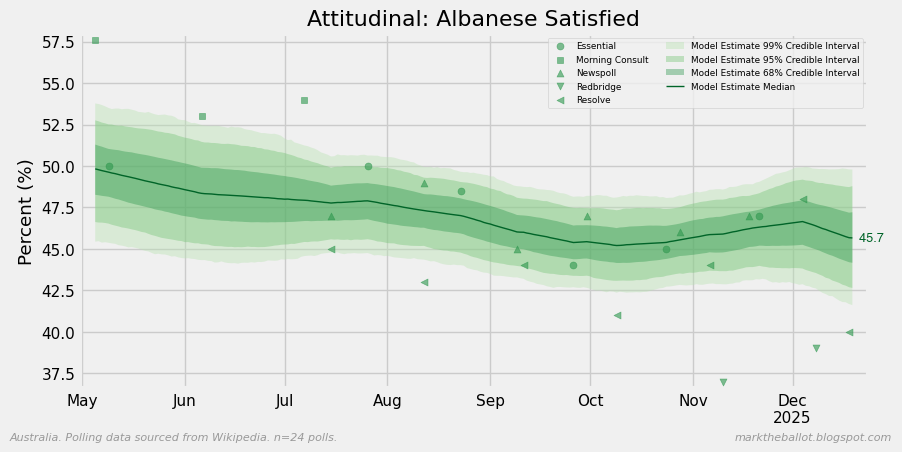


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.90
Minimum polls required: 5

Essential (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.924 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -1.71 (t-test p=0.100)

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.089 (homoskedastic)
  Recent outliers: 0@3σ, 1@2σ (of 5)
  Mean shift: +0.43 (t-test p=0.811)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.086 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +0.98 (t-test p=0.384)

✓ No pollsters flagged for methodology concerns.

Processing: Albanese Dissatisfied
Polls: 24
Pollsters: ['Resolve', 'Newspoll', 'Essential', 'Morning Consult', 'Redbridge']
Constraint: zero_median
sigma_obs HalfNormal prior: {'sigma': 5}
nu Gamma prior: {'alpha': 2, 'beta': 0.1}


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 5123
Maximum MCSE/sd ratio: 0.014
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (10): 0.41% (comparing to observed max)
Minimum BFMI: 0.98
Completed: Albanese Dissatisfied


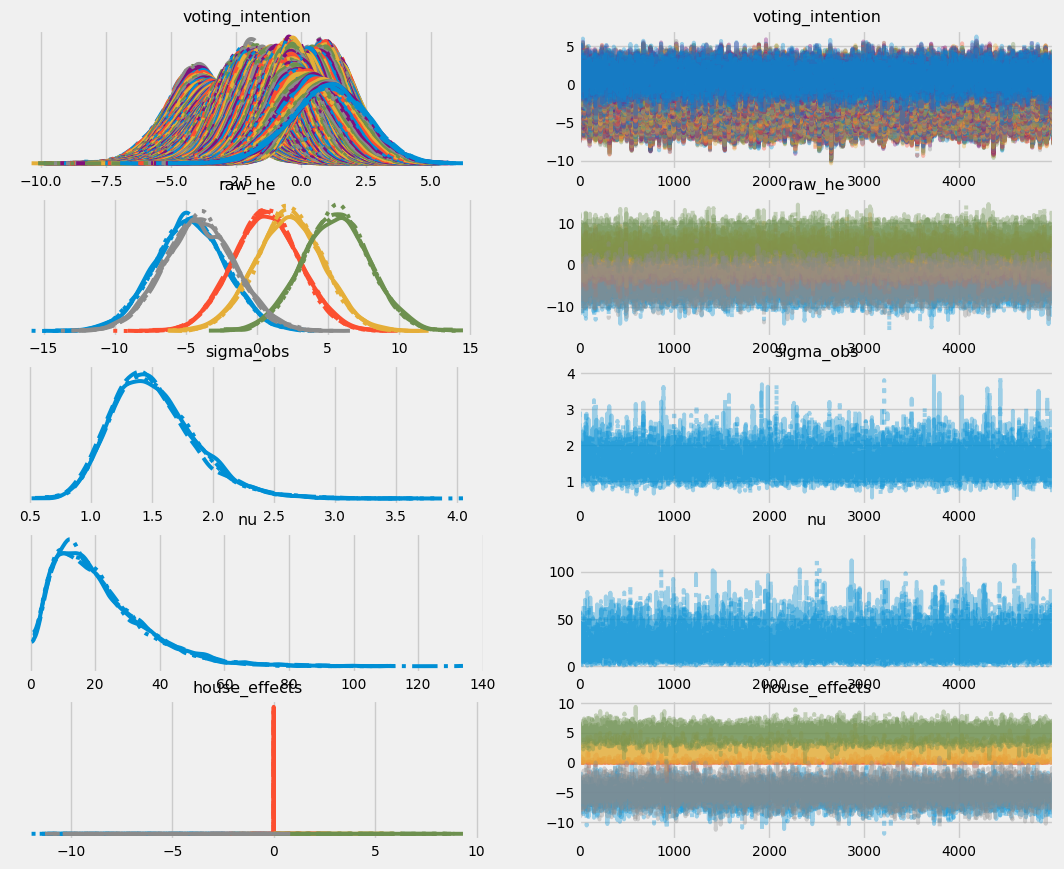

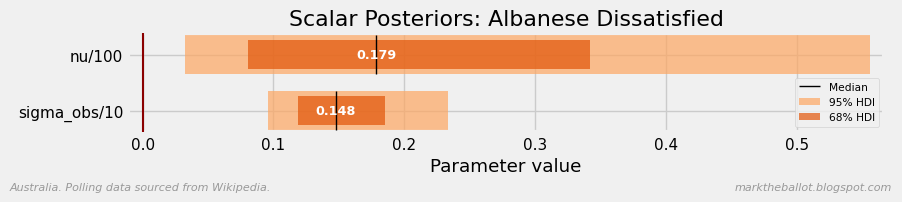

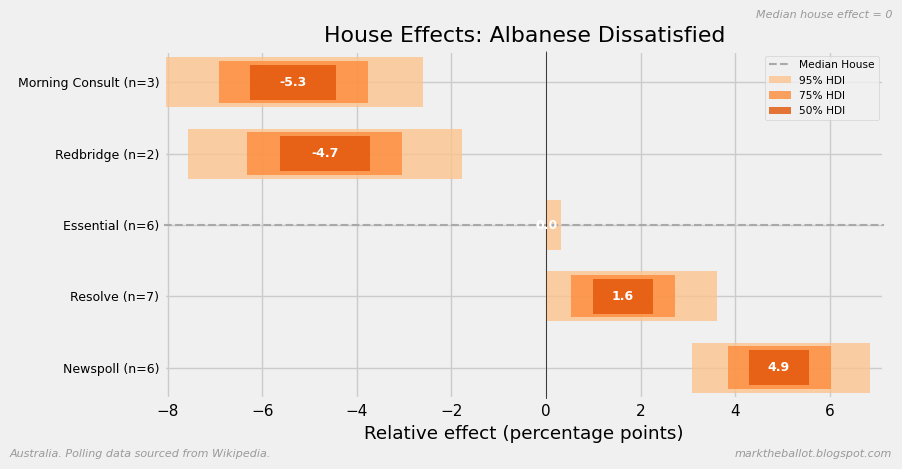

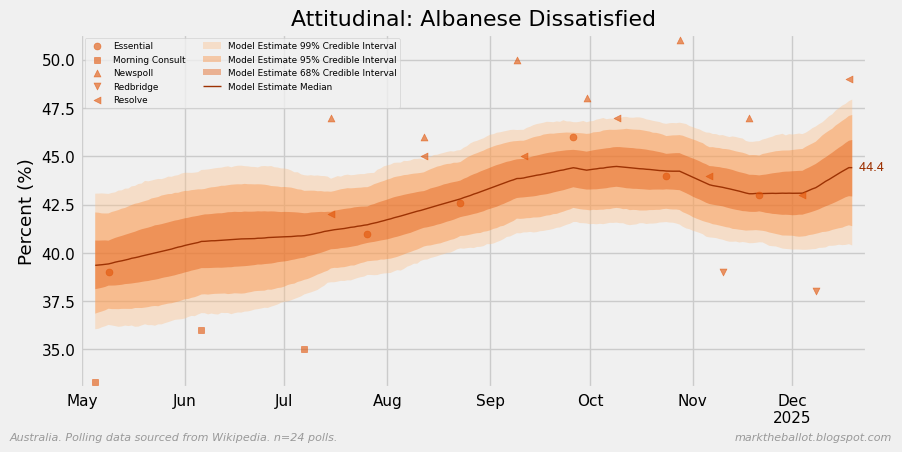


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.52
Minimum polls required: 5

Essential (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.858 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +0.83 (t-test p=0.298)

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.082 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +0.31 (t-test p=0.810)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.401 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.43 (t-test p=0.747)

✓ No pollsters flagged for methodology concerns.

Processing: Ley Satisfied
Polls: 20
Pollsters: ['Resolve', 'Newspoll', 'Essential', 'Redbridge']
Constraint: zero_median
sigma_obs HalfNormal prior: {'sigma': 5}
nu Gamma prior: {'alpha': 2, 'beta': 0.1}


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 4739
Maximum MCSE/sd ratio: 0.015
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (10): 0.04% (comparing to observed max)
Minimum BFMI: 0.99
Completed: Ley Satisfied


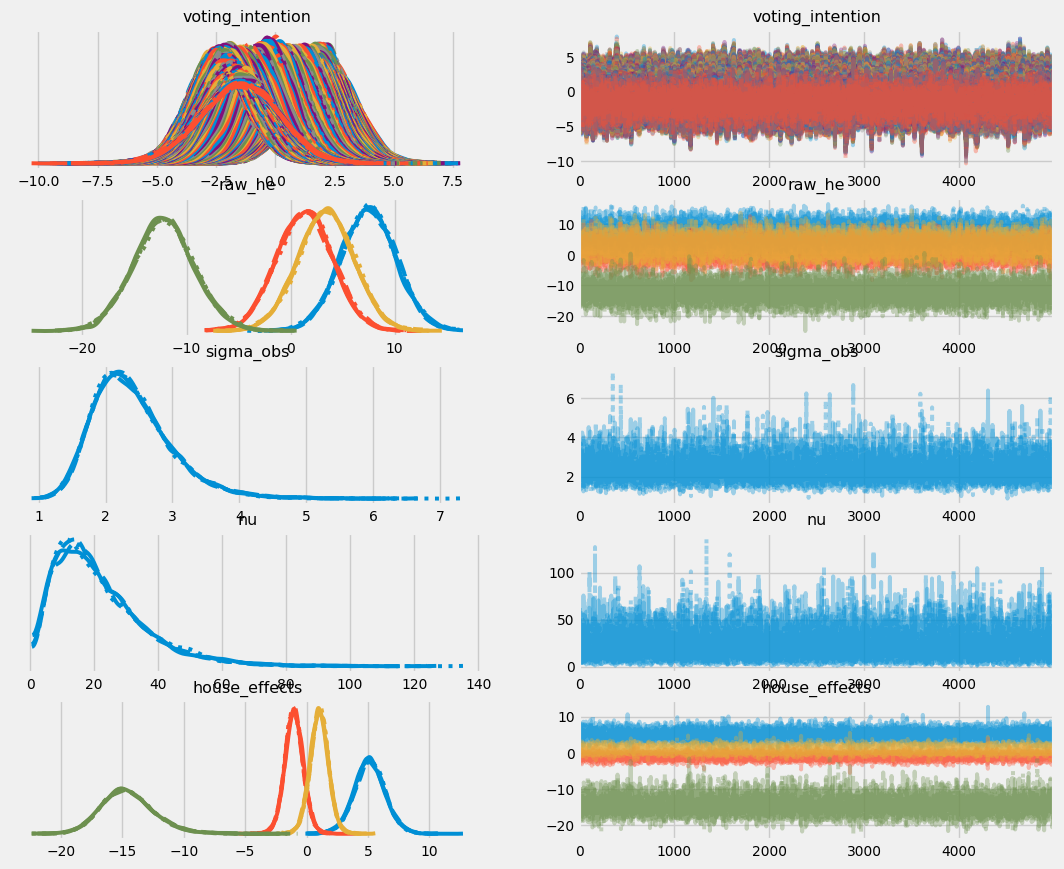

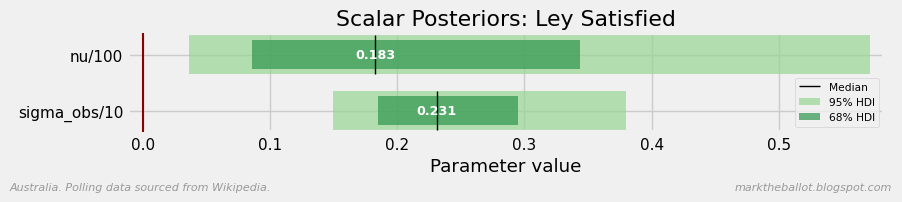

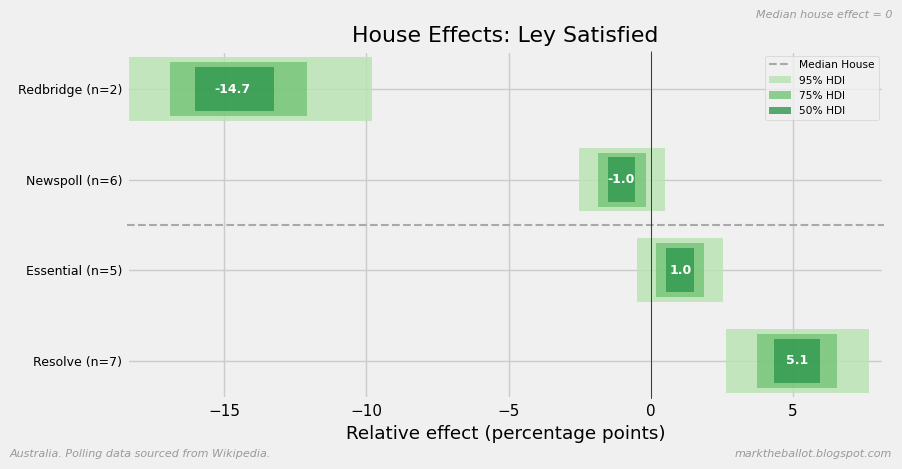

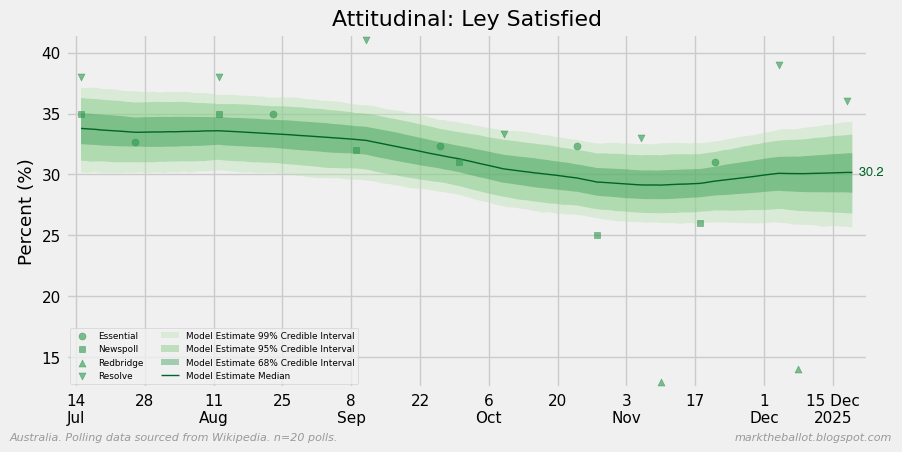


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 2.40
Minimum polls required: 5

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.480 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.26 (t-test p=0.896)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.699 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -3.26 (t-test p=0.100)

Essential (n=5)
  Outside ±3σ: 0/5 (0.0%)
  Heteroskedasticity p-value: 0.482 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.20 (t-test p=0.497)

✓ No pollsters flagged for methodology concerns.

Processing: Ley Dissatisfied
Polls: 20
Pollsters: ['Resolve', 'Newspoll', 'Essential', 'Redbridge']
Constraint: zero_median
sigma_obs HalfNormal prior: {'sigma': 5}
nu Gamma prior: {'alpha': 2, 'beta': 0.1}


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 4958
Maximum MCSE/sd ratio: 0.015
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (10): 0.05% (comparing to observed max)
Minimum BFMI: 0.96
Completed: Ley Dissatisfied


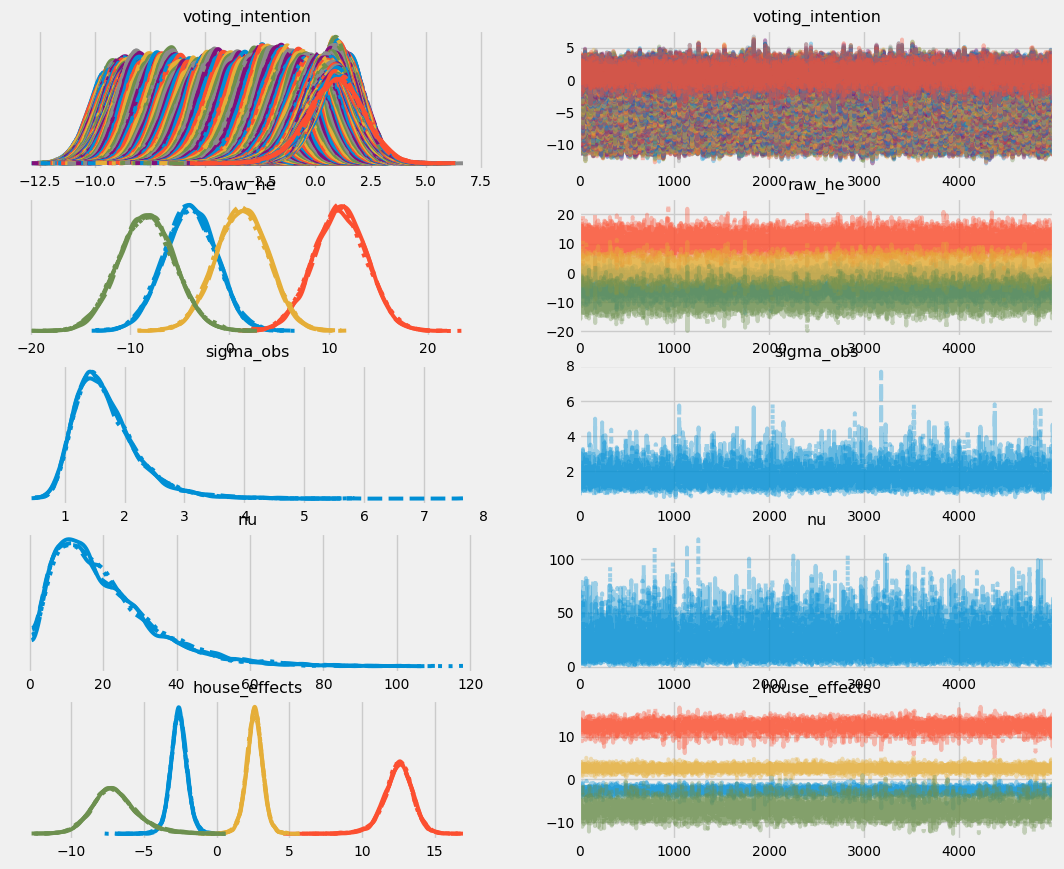

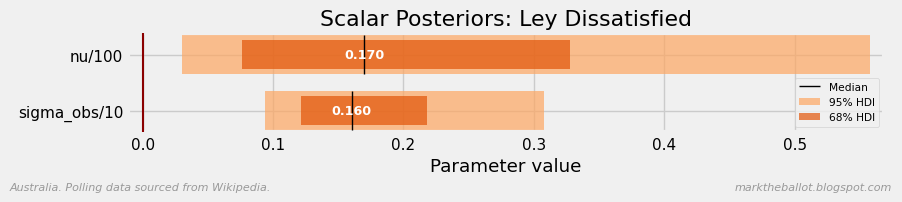

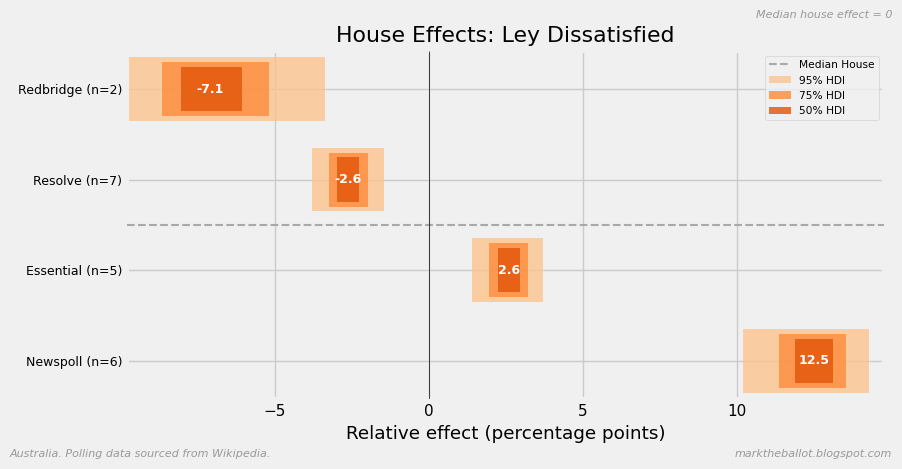

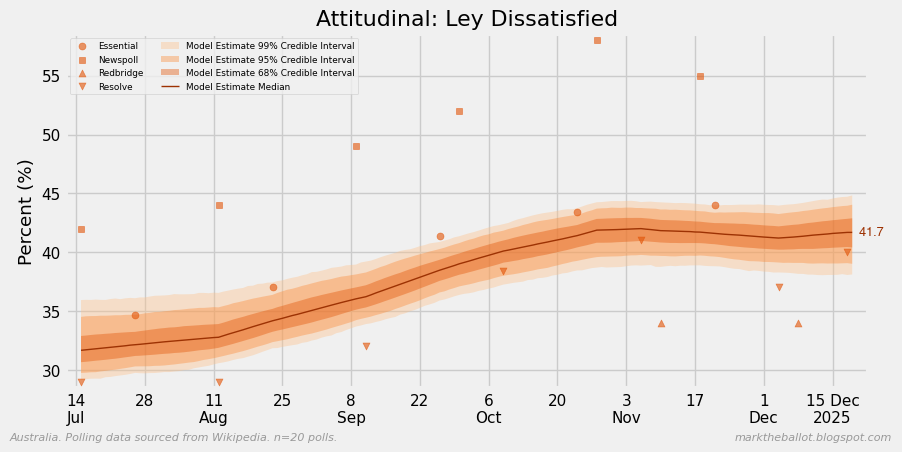


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.71
Minimum polls required: 5

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.385 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.52 (t-test p=0.134)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.761 (homoskedastic)
  Recent outliers: 0@3σ, 1@2σ (of 5)
  Mean shift: +2.75 (t-test p=0.103)

Essential (n=5)
  Outside ±3σ: 0/5 (0.0%)
  Heteroskedasticity p-value: 0.537 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.12 (t-test p=0.726)

✓ No pollsters flagged for methodology concerns.


In [11]:
# Run model for each column
# Note: Higher innovation (0.3) than voting intention (0.1) because attitudinal
# data is sparser and more volatile - we want the model to track real changes
# rather than attributing all variation to house effects.
INNOVATION = 0.3

results = {}

for column in ATTITUDINAL_COLUMNS:
    if column not in df.columns:
        print(f"Skipping {column} - not in data")
        continue
        
    result = run_grw_for_column(df, column, innovation=INNOVATION)
    
    if result is None:
        continue
        
    results[column] = result
    inputs = result["inputs"]
    idata = result["idata"]
    glitches = result["glitches"]
    constraint = result["constraint"]
    poll_counts = result["poll_counts"]
    
    # Plot scalar posteriors
    plot_posteriors_bar(
        idata,
        series_name=column,
        rfooter=RFOOTER,
        lfooter=LFOOTER,
        palette=get_palette(column),
        show=SHOW,
    )
    
    # Plot house effects
    if constraint == "zero_median":
        rheader = "Median house effect = 0"
    else:
        he_sum_inclusions = inputs["he_sum_inclusions"]
        rheader = f"Sum to zero: {', '.join(he_sum_inclusions)}"
    plot_house_effects_bar(
        idata,
        inputs["back_firm_map"],
        model_name=column,
        poll_counts=poll_counts,
        palette=get_palette(column),
        rheader=rheader,
        rfooter=RFOOTER,
        lfooter=LFOOTER,
        show=SHOW,
    )
    
    # Prepare poll data for plotting
    df_plot = df[df[column].replace(0, np.nan).notna()].copy()
    df_plot.index = pd.PeriodIndex(df_plot[MIDDLE_DATE], freq="D")
    n_polls = len(df_plot)
    
    # Plot time series
    vi_samples = get_vector_var("voting_intention", idata)
    vi_samples = vi_samples - inputs["centre_offset"]
    date_index = pd.period_range(inputs["day_zero"], periods=len(vi_samples), freq="D")
    vi_samples.index = date_index
    
    plot_posterior_timeseries(
        data=vi_samples,
        poll_data=df_plot,
        poll_column=column,
        election_result=None,  # No election benchmark for attitudinal
        palette=get_palette(column),
        title=f"Attitudinal: {column}",
        ylabel="Percent (%)",
        legend={"loc": "best", "fontsize": "xx-small", "ncol": 2},
        lheader=glitches if glitches else "",
        rfooter=RFOOTER,
        lfooter=f"{LFOOTER}n={n_polls} polls.",
        show=SHOW,
    )
    
    # Check residuals
    residual_df = check_residuals(inputs, idata, verbose=True, show=SHOW)

## Comparison Charts

Combined charts showing model estimates without individual poll markers.

In [12]:
def plot_comparison_chart(
    results: dict,
    columns: list[str],
    colors: list[str],
    labels: list[str],
    title: str,
    **kwargs,
) -> None:
    """Plot multiple model estimates on the same chart for comparison."""
    
    _, ax = plt.subplots(figsize=(12, 6))
    
    # Build DataFrames for credible intervals and medians
    median_df = pd.DataFrame()
    
    for column, color, label in zip(columns, colors, labels):
        if column not in results:
            print(f"Skipping {column} - not in results")
            continue
            
        result = results[column]
        inputs = result["inputs"]
        idata = result["idata"]
        
        # Extract voting intention samples
        vi_samples = get_vector_var("voting_intention", idata)
        vi_samples = vi_samples - inputs["centre_offset"]
        date_index = pd.period_range(inputs["day_zero"], periods=len(vi_samples), freq="D")
        
        # Calculate credible intervals
        lower_95 = vi_samples.quantile(0.025, axis=1)
        upper_95 = vi_samples.quantile(0.975, axis=1)
        lower_68 = vi_samples.quantile(0.16, axis=1)
        upper_68 = vi_samples.quantile(0.84, axis=1)
        
        # Build band DataFrames for mg.fill_between_plot
        band_95 = pd.DataFrame({
            "lower": lower_95.values,
            "upper": upper_95.values,
        }, index=date_index)
        
        band_68 = pd.DataFrame({
            "lower": lower_68.values,
            "upper": upper_68.values,
        }, index=date_index)
        
        # Plot credible intervals using mg.fill_between_plot
        ax = mg.fill_between_plot(
            band_95, ax=ax, color=color, alpha=0.15,
            label=f"{label} 95% CI",
        )
        ax = mg.fill_between_plot(
            band_68, ax=ax, color=color, alpha=0.25,
            label=f"{label} 68% CI",
        )
        
        # Store median for combined line plot
        median_df[label] = pd.Series(vi_samples.quantile(0.5, axis=1).values, index=date_index)
    
    # Plot median lines using mg.line_plot with annotation
    mg.line_plot(
        median_df,
        ax=ax,
        color=colors,
        width=2,
        annotate=True,
    )
    
    mg.finalise_plot(
        ax,
        title=title,
        ylabel="Percent (%)",
        legend={"loc": "best", "fontsize": "x-small", "ncol": 2},
        rfooter=RFOOTER,
        lfooter=LFOOTER,
        show=SHOW,
        **kwargs,
    )

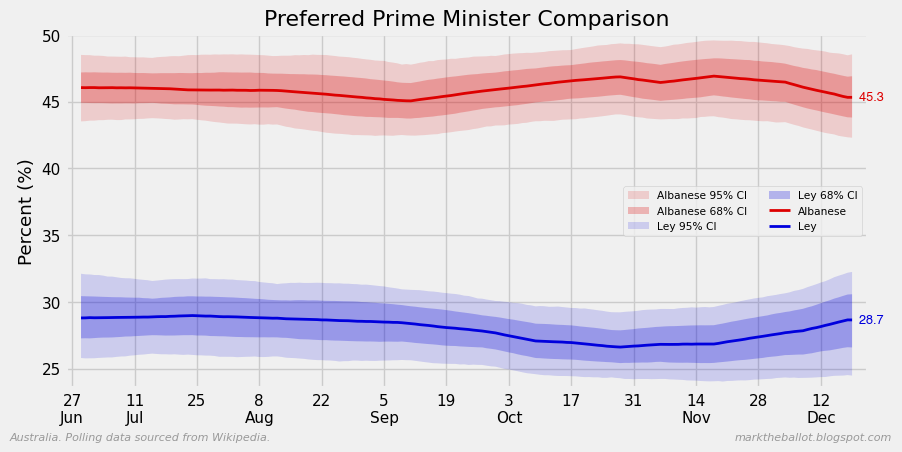

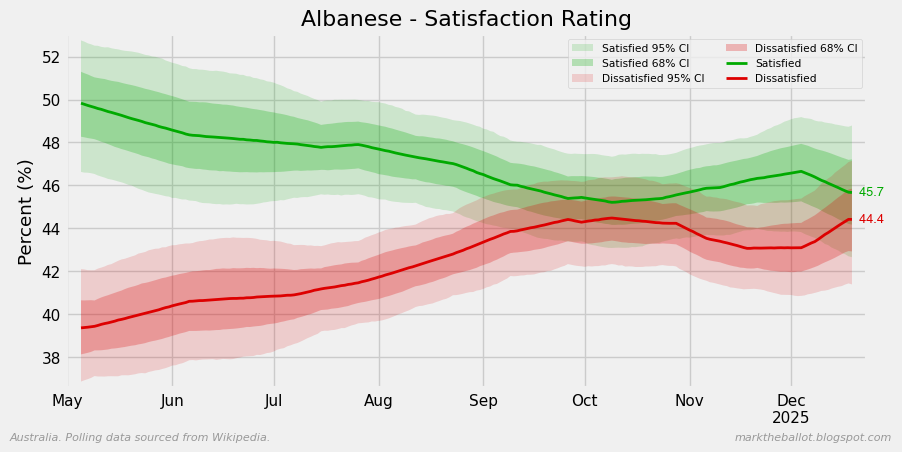

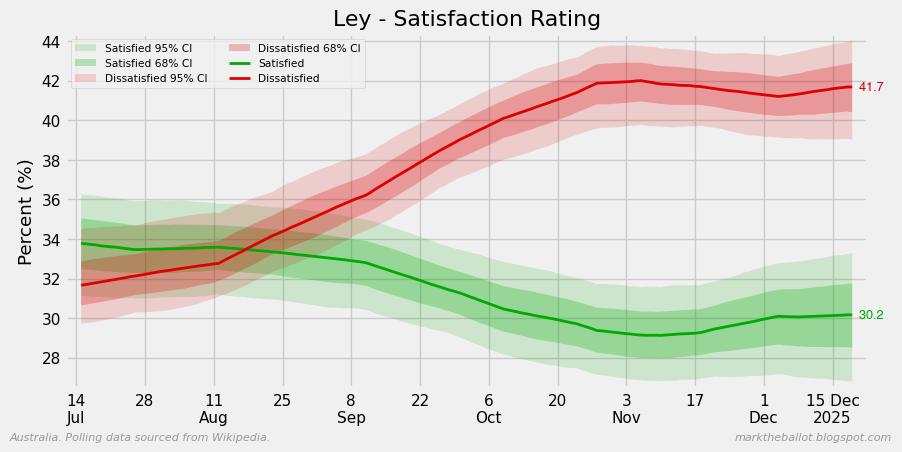

In [13]:
# Preferred Prime Minister comparison
plot_comparison_chart(
    results,
    columns=["Preferred prime minister Albanese", "Preferred prime minister Ley"],
    colors=["#dd0000", "#0000dd"],
    labels=["Albanese", "Ley"],
    title="Preferred Prime Minister Comparison",
)

# Albanese Satisfaction comparison
plot_comparison_chart(
    results,
    columns=["Albanese Satisfied", "Albanese Dissatisfied"],
    colors=["#00aa00", "#dd0000"],
    labels=["Satisfied", "Dissatisfied"],
    title="Albanese - Satisfaction Rating",
)

# Ley Satisfaction comparison  
plot_comparison_chart(
    results,
    columns=["Ley Satisfied", "Ley Dissatisfied"],
    colors=["#00aa00", "#dd0000"],
    labels=["Satisfied", "Dissatisfied"],
    title="Ley - Satisfaction Rating",
)

## Finished

In [14]:
%load_ext watermark
%watermark -t -d -u --python --machine --conda --iversions --watermark

Last updated: 2025-12-30 13:32:52

Python implementation: CPython
Python version       : 3.14.0
IPython version      : 9.8.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pathlib   : 1.0.1
pandas    : 2.3.3
arviz     : 0.22.0
numpy     : 2.3.5
matplotlib: 3.10.7
sys       : 3.14.0 (main, Oct 10 2025, 12:54:13) [Clang 20.1.4 ]
mgplot    : 0.2.14

Watermark: 2.5.0

